# Use IMPA for unseen perturbation prediction cpg0000

In [82]:
# Standard library imports
import os
from pathlib import Path

# Third-party library imports
from tutorial_utils import t2np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml 
import torch
from omegaconf import OmegaConf
from tqdm import tqdm


# Local application/library imports
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule

Read the configuration of interest

In [83]:
path_to_config = "../config_hydra/config/cpg0000.yaml"

In [84]:
# Reading the YAML file
with open(path_to_config, 'r') as file:
    config = yaml.safe_load(file)  # Use safe_load to avoid executing arbitrary code

# Access the loaded data
print(config)

{'task_name': 'cpg0000', 'img_size': 96, 'latent_dim': 100, 'hidden_dim': 512, 'style_dim': 64, 'stochastic': True, 'z_dimension': 20, 'dim_in': 64, 'lambda_reg': 1, 'lambda_cyc': 1, 'lambda_sty': 1, 'lambda_ds': 1, 'total_epochs': 100, 'ds_iter': 200000, 'resume_iter': 0, 'batch_size': 32, 'val_batch_size': 20, 'lr': 0.0001, 'f_lr': 0.0001, 'beta1': 0, 'beta2': 0.99, 'weight_decay': 0.0001, 'num_outs_per_domain': 10, 'single_style': True, 'ood_set': None, 'mol_list': None, 'balanced': False, 'trainable_emb': False, 'dataset_name': 'cpg0000', 'n_channels': 5, 'num_workers': 6, 'seed': 42, 'multimodal': True, 'batch_correction': False, 'batch_key': None, 'use_condition_embeddings': False, 'add_controls': False, 'condition_embedding_dimension': None, 'n_mod': 1, 'modality_list': ['CRISPR', 'Compound', 'ORF'], 'image_path': 'project_folder/datasets/cpg0000/cpg0000_u2os_normalized_segmented_large_transported', 'data_index_path': 'project_folder/datasets/cpg0000/metadata/metadata_large_gene

In [23]:
config["image_path"] = "../" + config["image_path"]
config["data_index_path"] = "../" + config["data_index_path"]
config["embedding_path"] = {key: "../" + value for key, value in config["embedding_path"].items()}

In [43]:
metadata = pd.read_csv(config["data_index_path"])

Initialize the configuration

In [28]:
args = OmegaConf.create(config)

Initialize the dataset

In [26]:
dataloader = CellDataLoader(args)

['transform_cells_bbbc021_six_drugs.ipynb', 'transform_cells_cpg0000_batch_corr.ipynb', 'transform_cells_rxrx1_batch_corr.ipynb', '__pycache__', 'transform_cells_bbbc021_all_unseen_prediction.ipynb', '.ipynb_checkpoints', 'transform_cells_cpg0000_pert_prediction.ipynb', 'tutorial_utils.py']


In [85]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

Checkpoint location 

In [86]:
checkpoint_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20241204_b30c5630-36a6-451c-8cb3-233edae9eae6_cpg0000"

In [87]:
solver = IMPAmodule(args, checkpoint_dir, dataloader)
solver._load_checkpoint(90)

Number of parameters in generator: 24319877
Number of parameters in style_encoder: 14330624
Number of parameters in discriminator: 14681003
Number of parameters in mapping_network: 132544
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): ModuleList(
    (0): Embedding(296, 328)
    (1): Embedding(296, 1224)
    (2): Embedding(155, 456)
  )
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm

Map cpd name to broad ID

In [88]:
broad_sample_to_cpd_name = dict(zip(metadata.CPD_NAME, metadata.BROAD_SAMPLE))
broad_sample_to_cpd_name

{'DMSO': 'DMSO',
 'HTR2C': 'ccsbBroad304_00805',
 'CYP2A6': 'BRDN0001479298',
 'ADA': 'BRDN0001486925',
 'flupirtine': 'BRD-K50720187-051-03-1',
 'PDE3A': 'BRDN0001054361',
 'ELANE': 'BRDN0001482390',
 'CYM-5520': 'BRD-K29151923-001-01-5',
 'none': 'BRDN0001147812',
 'ATM': 'ccsbBroad304_10688',
 'AKT1': 'BRDN0001054985',
 'PETCM': 'BRD-A93477898-001-04-2',
 'A205804': 'BRD-K77627880-001-04-0',
 'PLK1': 'ccsbBroad304_14770',
 'ML-228': 'BRD-K44432556-001-05-5',
 'JAK1': 'BRDN0001065858',
 'KCNH7': 'BRDN0001486718',
 'EZH2': 'BRDN0001057455',
 'NAMPT': 'BRDN0001484730',
 'ICAM1': 'BRDN0000734502',
 'KCNK1': 'ccsbBroad304_06483',
 'SGX523': 'BRD-K19477839-001-07-6',
 'WH-4-023': 'BRD-K50199947-001-03-4',
 'SLIRP': 'ccsbBroad304_09091',
 'torcitabine': 'BRD-K91822704-003-07-2',
 'PPARD': 'BRDN0001065187',
 'olanzapine': 'BRD-K18895904-001-16-1',
 'HSD11B1': 'BRDN0001488463',
 'RB1': 'ccsbBroad304_06846',
 'KCNQ2': 'BRDN0001489498',
 'IGF1R': 'BRDN0001065728',
 'FPR1': 'BRDN0000990355',
 '

A list of active compounds 

In [89]:
pert_to_inspect = [
                    "1-octanol", "7-hydroxystaurosporine", "AVL-292", "AZD7762", "BI-2536", "BMS-536924", 
                      "BVT-948", "GK921", "GSK1070916", "GSK2110183", "ITGB2", "KG-5", "NSC-663284", 
                      "NSC-95397", "PP-121", "RGB-286638", "SU3327", "TG-02", "TG-101348", "UNC1999", 
                      "UNC2025", "anisomycin", "azeliragon", "briciclib", "colchicine", "delanzomib", 
                      "dexamethasone", "homoharringtonine", "ibutamoren", "ixabepilone", "oxibendazole",
                      "ponatinib", "puromycin", "pyrrolidine-dithiocarbamate", "romidepsin", "ryuvidine"
                  ]

pert_to_inspect_broad = [broad_sample_to_cpd_name[d] for d in pert_to_inspect]

In [90]:
transf_images = {}
real_images = {}

with torch.no_grad():
    for batch in val_dataloader:
        X_ctr = batch["X"][0]
        for pert in tqdm(pert_to_inspect_broad):
            z = torch.randn(X_ctr.shape[0], args.z_dimension).cuda()
            try:
                id_pert = dataloader.mol2id["Compound"][pert]*torch.ones(X_ctr.shape[0]).long().cuda()
            except:
                continue
            y = solver.embedding_matrix[1](id_pert)
            y = torch.cat([y, z], dim=1)
            y = solver.nets.mapping_network(y, None ,1)
            _, X_generated = solver.nets.generator(X_ctr, y)
            transf_images[pert] = t2np(X_generated.detach().cpu(), batch_dim=True)
            real_images[pert] = t2np(X_ctr.detach().cpu(), batch_dim=True)
        break

100%|██████████| 36/36 [00:01<00:00, 19.21it/s]


Control 0


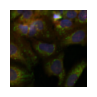

Pert BRD-K09338665-001-08-9


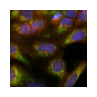

Pert BRD-K45293975-001-02-0


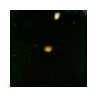

Pert BRD-K87782578-001-01-4


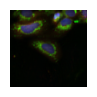

Pert BRD-K86525559-001-07-8


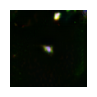

Pert BRD-K64890080-001-02-1


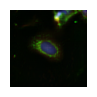

Pert BRD-K34581968-001-05-3


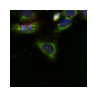

Pert BRD-A22713669-001-04-3


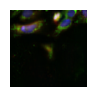

Pert BRD-K38272302-001-02-7


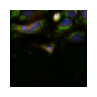

Pert BRD-K36740062-001-06-6


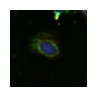

Pert BRD-K25412176-001-01-9


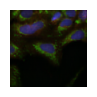

Pert BRD-K90747162-001-01-4


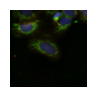

Pert BRD-K03109492-001-02-2


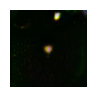

Pert BRD-K68143200-001-11-7


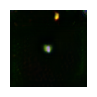

Pert BRD-K81801188-001-02-8


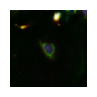

Pert BRD-K20986415-001-02-6


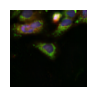

Pert BRD-K32730239-001-01-0


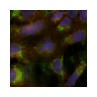

Pert BRD-K14560436-001-01-4


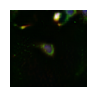

Pert BRD-K12502280-001-11-4


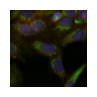

Pert BRD-K26989966-001-04-3


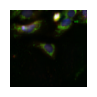

Pert BRD-K91283740-003-01-6


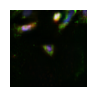

Pert BRD-K91370081-001-25-1


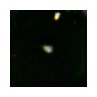

Pert BRD-K51899933-001-02-6


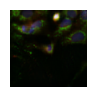

Pert BRD-K05531427-001-01-7


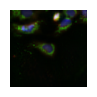

Pert BRD-K00259736-001-16-4


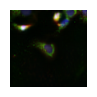

Pert BRD-K59325863-001-04-4


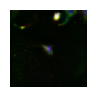

Pert BRD-K38775274-001-22-1


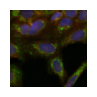

Pert BRD-K76674262-001-03-3


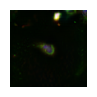

Pert BRD-K44771174-066-01-0


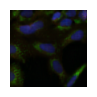

Pert BRD-K03601870-001-01-2


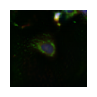

Pert BRD-K52075715-001-06-7


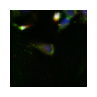

Pert BRD-K44227013-001-08-0


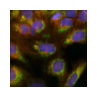

Pert BRD-K01824976-300-02-9


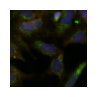

Pert BRD-K80970344-201-08-6


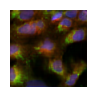

Pert BRD-K61397605-001-01-8


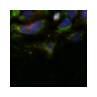

Pert BRD-K06426971-001-02-7


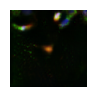

In [94]:
for i, pert in enumerate(real_images):
    if i == 0:
        print(f"Control {i}")
        plt.figure(figsize=(1, 1))
        plt.imshow(real_images[pert][0][:,:,[0,3,4]])
        plt.axis("off")
        plt.show()
    print(f"Pert {pert}")
    plt.figure(figsize=(1, 1))
    plt.imshow(transf_images[pert][0][:,:,[0,3,4]])
    plt.axis("off")
    plt.show()

In [92]:
i

34

In [75]:
real_images.keys()

dict_keys(['BRD-K09338665-001-08-9', 'BRD-K45293975-001-02-0', 'BRD-K87782578-001-01-4', 'BRD-K86525559-001-07-8', 'BRD-K64890080-001-02-1', 'BRD-K34581968-001-05-3', 'BRD-A22713669-001-04-3', 'BRD-K38272302-001-02-7', 'BRD-K36740062-001-06-6', 'BRD-K25412176-001-01-9', 'BRD-K90747162-001-01-4', 'BRD-K03109492-001-02-2', 'BRD-K68143200-001-11-7', 'BRD-K81801188-001-02-8', 'BRD-K20986415-001-02-6', 'BRD-K32730239-001-01-0', 'BRD-K14560436-001-01-4', 'BRD-K12502280-001-11-4', 'BRD-K26989966-001-04-3', 'BRD-K91283740-003-01-6', 'BRD-K91370081-001-25-1', 'BRD-K51899933-001-02-6', 'BRD-K05531427-001-01-7', 'BRD-K00259736-001-16-4', 'BRD-K59325863-001-04-4', 'BRD-K38775274-001-22-1', 'BRD-K76674262-001-03-3', 'BRD-K44771174-066-01-0', 'BRD-K03601870-001-01-2', 'BRD-K52075715-001-06-7', 'BRD-K44227013-001-08-0', 'BRD-K01824976-300-02-9', 'BRD-K80970344-201-08-6', 'BRD-K61397605-001-01-8', 'BRD-K06426971-001-02-7'])